<a href="https://colab.research.google.com/github/wwang2/Coarse-Graining-Auto-encoders/blob/master/cgae_alanine_dipeptide_colab_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this notbook you will use a Coarse-Grained Autoencoder applied on Alanine Dipeptide Trajectores. The code is SUPER simple. 

First you will need to install some packages. This might take a few miniutes. 

In [6]:
! pip install nglview
! pip install ase
! pip install mdtraj
! pip install mdshare

     |████████████████████████████████| 86 kB 2.8 MB/s 
  Created wheel for mdshare: filename=mdshare-0.4.1-py3-none-any.whl size=20180 sha256=e81cc1dea70d71c118517ceaf38e8a7f98a44adc05778dbb36cedb2c31cff22f
  Stored in directory: /root/.cache/pip/wheels/37/95/85/b8ce5c22b10bd060e3b16895739a8973cc7a54f87de5c37fdd
Successfully built mdshare


In [12]:
import torch
from torch import nn
import numpy as np
import mdshare 
import mdtraj as md 
import glob
import torch.nn.functional as F
from ase import Atoms
from nglview import show_ase
import matplotlib.pyplot as plt

# this is needed is you want to use nglview to visualize reconstructed coordinates 
from google.colab import output
output.enable_custom_widget_manager()

In [8]:
# load alanine dipeptide trajectory 
mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')

xtc_files = glob.glob('./data/alanine-dipeptide-*-250ns-nowater.xtc')
traj = [md.load_xtc(file, top='./data/alanine-dipeptide-nowater.pdb') for file in xtc_files]

traintraj = md.join(traj[:-1])
testtraj = traj[-1]

In [10]:
# build dataset and dataloader 
train_xyz = torch.Tensor( traintraj.xyz[::1000]) * 10.0 # take 500 data points 
test_xyz = torch.Tensor( testtraj.xyz[::1000])* 10.0

trainset = torch.utils.data.TensorDataset(train_xyz)
testset = torch.utils.data.TensorDataset(test_xyz)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [13]:
# define a CGAE

class cgae(nn.Module):
    
    def __init__(self, n_atoms, n_cgs):
        super().__init__()

        assign_map = torch.randn(n_atoms, n_cgs)
        decode = torch.randn(n_cgs, n_atoms)
        
        
        self.n_atoms = n_atoms 
        self.assign_map = nn.Parameter(assign_map)
        self.decode = nn.Parameter(decode)
        
    def forward(self, xyz, tau=1.0):
        
        # recenter coordinates 
        xyz = xyz.reshape(-1, self.n_atoms, 3)
        shift = xyz.mean(1)
        xyz = xyz - shift.unsqueeze(1)
        
        # get discrete assignment map
        M = F.gumbel_softmax(self.assign_map, dim=-1)
        M_norm = M / M.sum(-2).unsqueeze(-2)
        
        cg_xyz = torch.einsum('bij,in->bnj', xyz, M_norm)
        xyz_recon = torch.einsum('bnj,ni->bij', cg_xyz, self.decode)
        
        return xyz, xyz_recon, M, cg_xyz

In [14]:
# Define the latent CG dimension, feel free to set your own, it only needs to be smaller than the number of total atoms 

device = "cpu" # device cardinal
N_cg = 6 # play with this by yourself. 
ae = cgae(train_xyz.shape[1], N_cg).to(device)

optimizer = torch.optim.Adam(list(ae.parameters()), lr=4e-3)

In [15]:
# training loop
tau = 1.0

for epoch in range(600):
    all_loss = []
    all_reg = []
    all_recon = [] 
    for i, xyz in enumerate(trainloader):
        
        # recenter xyz 
        xyz = xyz[0].to(device)

        # encode and decode coordinates 
        xyz, xyz_recon, M, cg_xyz = ae(xyz, tau)
        
        # lift the cg_xyz back to the FG space 
        X_lift = torch.einsum('bij,ni->bnj', cg_xyz, M)
        
        # compute regularization to penalize atoms that are assigned too far away 
        loss_reg = (xyz - X_lift).pow(2).sum(-1).mean()
        
        # comput reconstruction 
        loss_recon = (xyz - xyz_recon).pow(2).mean() 
        loss = loss_recon + 0.5 * loss_reg
        
        all_reg.append(loss_reg.item())
        all_recon.append(loss_recon.item())
        all_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        all_loss.append(loss.item())

    # temperature scheduler for gubmel softmax     
    if tau >= 0.1:
        tau -= 0.001
    if epoch == 0:
      print("epoch", "tau", "reconstruction", "regularization loss")
    print(epoch, tau, np.array(all_recon).mean(), np.array(all_reg).mean())

0 0.999 4.294854983687401 7.4603623151779175
1 0.998 4.375009089708328 7.349484384059906
2 0.997 4.2070416659116745 7.406867623329163
3 0.996 3.9814601689577103 7.359523355960846
4 0.995 3.6245413571596146 7.483359485864639
5 0.994 3.473364368081093 7.5714529156684875
6 0.993 3.644391879439354 7.55017352104187
7 0.992 3.56270132958889 7.418772727251053
8 0.991 3.7593474239110947 7.4002450704574585
9 0.99 3.5825213193893433 7.389072149991989
10 0.989 3.308906376361847 7.466612368822098
11 0.988 3.1814601719379425 7.3782017827034
12 0.987 3.319797709584236 7.302591264247894
13 0.986 3.1550315022468567 7.247085839509964
14 0.985 2.9351009726524353 7.432676166296005
15 0.984 2.901960641145706 7.295782655477524
16 0.983 2.9423000514507294 7.120155513286591
17 0.982 2.762089803814888 7.178207546472549
18 0.981 2.493174210190773 7.145371586084366
19 0.98 2.1548130735754967 6.943065911531448
20 0.979 2.4096569567918777 7.150737911462784
21 0.978 2.1900849640369415 7.085721731185913
22 0.977 1.

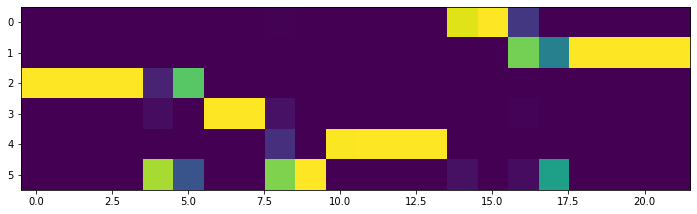

In [17]:
# visualize the learned CG assignment 
plt.figure(figsize=(12,20))
plt.imshow(M.t().detach().cpu().numpy())
plt.show()

In [26]:
# visualze reconstructed alanine dipeptide 
atomic_nums = [atom.element.atomic_number for atom in traintraj.top.atoms] 
reconstructed_xyz = xyz_recon[0].detach().cpu().numpy()
recon_alaine_dipep = Atoms(positions= reconstructed_xyz, numbers=atomic_nums)
show_ase(recon_alaine_dipep)

NGLWidget()

In [25]:
# visualize Coarse-Grained alanine dipeptide
cg_nums = [1] * N_cg
cg_alaine_dipep = Atoms(positions= cg_xyz[0].detach().cpu().numpy(), numbers=cg_nums)
show_ase(cg_alaine_dipep)

NGLWidget()